# Imports

<div style="display:fill;
           background-color:#89B9AD88;
           letter-spacing:0.5px;border-bottom: 2px solid black;">
    
<h1 style="padding: 12px; color:black; font-weight:600;font-family: 'Garamond', 'Lucida Sans', sans-serif; text-align: center; font-size: 32px;text-transform: uppercase;">Parkinson's Freezing of Gait Prediction</h1>
</div>

# Introduction

The goal of this competition is to **detect freezing of gait (FOG)**, a debilitating symptom that afflicts many people **with Parkinson’s disease**. It is required to **develop a machine learning model trained on data collected from a wearable 3D lower back sensor** to better understand **when and why FOG episodes occur**.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,iplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from catboost import Pool, CatBoostClassifier, cv
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import average_precision_score,classification_report
from sklearn.ensemble import RandomForestClassifier
import optuna
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

<div style="background-color: #89B9AD88; padding: 12px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 32px;">
    📝 Table of Contents
    </h1>
</div>
<br>
<a href="#1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 18px;"> 1. Dataset Overview </a><br>
<a href="#2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 18px;"> 2. EDA </a><br>
<a href="#3" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 18px;"> 3. Simple Data Preprocessing </a><br>
<a href="#4" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 18px;"> 4. Training Models </a><br>
<a href="#4.1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 14px;padding-left: 25px;"> 4.1 Logistic Regression Model </a><br>
<a href="#4.2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 14px;padding-left: 25px;"> 4.2 Baseline LGBM Model </a>

<div id="1" style="background-color: #89B9AD88; padding: 12px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 32px;">
   📚 Dataset Overview
    </h1>
</div>

**We have two major datasets here - tdcsfog and defog. Lets see the description and content of these datasets.**
**The tdcsfog folder includes** more than 800 csv files and accounts for **the majority of the information contained in the whole dataset for this competition**. Moreover, csv files in the edcsfog folder include annotation: StartHesitation, Turn, and Walking.

In [2]:
tdcsfog_003f117e14 = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/003f117e14.csv')
tdcsfog_003f117e14.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-9.533939,0.566322,-1.413525,0,0,0
1,1,-9.536140,0.564137,-1.440621,0,0,0
2,2,-9.529345,0.561765,-1.429332,0,0,0
3,3,-9.531239,0.564227,-1.415490,0,0,0
4,4,-9.540825,0.561854,-1.429471,0,0,0


In [3]:
tdcsfog_003f117e14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4682 entries, 0 to 4681
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4682 non-null   int64  
 1   AccV             4682 non-null   float64
 2   AccML            4682 non-null   float64
 3   AccAP            4682 non-null   float64
 4   StartHesitation  4682 non-null   int64  
 5   Turn             4682 non-null   int64  
 6   Walking          4682 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 256.2 KB


In [4]:
tdcsfog_003f117e14.describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
count,4682.00000,4682.000000,4682.000000,4682.000000,4682.0,4682.000000,4682.0
mean,2340.50000,-9.151214,0.753518,2.471637,0.0,0.168304,0.0
std,1351.72131,1.384390,1.102125,2.239906,0.0,0.374176,0.0
min,0.00000,-23.796051,-9.097370,-7.353417,0.0,0.000000,0.0
25%,1170.25000,-9.537719,0.322877,1.966646,0.0,0.000000,0.0
50%,2340.50000,-9.234702,0.580891,3.137857,0.0,0.000000,0.0
75%,3510.75000,-8.470460,1.368355,3.819931,0.0,0.000000,0.0
max,4681.00000,-3.915590,5.996704,10.281080,0.0,1.000000,0.0


The "mean", "std", "min", "25%", "50%", "75%", and "max" values for each variable provide information about the distribution and range of the data. For example, the mean value for "AccV" is -9.15, indicating that the device was tilted slightly downwards on average. The standard deviation of 1.38 for "AccV" suggests that the device orientation varied quite a bit over time. The maximum and minimum values for each variable provide an idea of the range of motion that was captured by the sensor over the course of the data collection period.

Here, **only Turn has the max value of 1**. Thus, **only a turn event occurred** in this experiment.

In [5]:
defog_02ea782681 = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/02ea782681.csv')
defog_02ea782681.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-1.0,0.044129,-0.25,0,0,0,False,False
1,1,-1.0,0.034431,-0.25,0,0,0,False,False
2,2,-1.0,0.031250,-0.25,0,0,0,False,False
3,3,-1.0,0.031250,-0.25,0,0,0,False,False
4,4,-1.0,0.031250,-0.25,0,0,0,False,False


In [6]:
defog_02ea782681.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162907 entries, 0 to 162906
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             162907 non-null  int64  
 1   AccV             162907 non-null  float64
 2   AccML            162907 non-null  float64
 3   AccAP            162907 non-null  float64
 4   StartHesitation  162907 non-null  int64  
 5   Turn             162907 non-null  int64  
 6   Walking          162907 non-null  int64  
 7   Valid            162907 non-null  bool   
 8   Task             162907 non-null  bool   
dtypes: bool(2), float64(3), int64(4)
memory usage: 9.0 MB


In [7]:
defog_02ea782681.describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
count,162907.000000,162907.000000,162907.000000,162907.000000,162907.0,162907.000000,162907.0
mean,81453.000000,-0.981353,0.032566,-0.187772,0.0,0.000792,0.0
std,47027.344489,0.073798,0.078877,0.189960,0.0,0.028129,0.0
min,0.000000,-2.764595,-1.063250,-1.270626,0.0,0.000000,0.0
25%,40726.500000,-1.000000,0.000000,-0.265625,0.0,0.000000,0.0
50%,81453.000000,-1.000000,0.031250,-0.234468,0.0,0.000000,0.0
75%,122179.500000,-0.968750,0.046875,-0.203125,0.0,0.000000,0.0
max,162906.000000,0.156229,1.501629,0.343750,0.0,1.000000,0.0


This table appears to contain sensor data and annotations related to a task performed by a subject. The columns **"Time", "AccV", "AccML", and "AccAP" likely contain motion sensor data similar to the previous examples**.

The columns "StartHesitation", "Turn", and "Walking" appear to correspond to whether the subject is performing certain activities at each time point, similar to the previous example. However, in this case, there are **additional columns "Valid" and "Task" that provide information about the validity of the annotations and the task performed**.

The **"Valid"** column appears to indicate whether the annotations for a given time point are considered to be **reliable or not**. The **"Task"** column appears to indicate whether the task was performed during a given time point. Portions of the data marked **"False"** in this column should be considered **unannotated and not used in analysis**.

It's possible that this dataset was collected in the context of studying movement disorders or other neurological conditions, where accurate annotation of sensor data is important for clinical diagnosis and treatment planning. **This dataset could potentially be used to develop machine learning models to predict task performance or identify patterns of sensor data associated with certain movements or behaviors.** However, given the additional complexity introduced by the "Valid" and "Task" columns, **careful attention** would need to be paid to cleaning and preprocessing the data before using it for analysis or modeling.

In [8]:
tdcsfog_path= '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog'
tdcsfog_list= []

for file_name in os.listdir(tdcsfog_path):
    if file_name.endswith('.csv'):
        file_path= os.path.join(tdcsfog_path,file_name)
        df= pd.read_csv(file_path)
        df['Time']= df['Time']/(len(df)-1) 
        tdcsfog_list.append(df)
     
tdcsfog = pd.concat(tdcsfog_list,axis= 0)
tdcsfog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0.000000,-9.665890,0.042550,0.184744,0,0,0
1,0.000135,-9.672969,0.049217,0.184644,0,0,0
2,0.000270,-9.670260,0.033620,0.193790,0,0,0
3,0.000405,-9.673356,0.035159,0.184369,0,0,0
4,0.000541,-9.671458,0.043913,0.197814,0,0,0
...,...,...,...,...,...,...,...
5153,0.999224,-9.915920,-0.105897,-1.123455,0,0,0
5154,0.999418,-9.693752,-0.066892,-1.114903,0,0,0
5155,0.999612,-9.548118,-0.098315,-1.112123,0,0,0
5156,0.999806,-9.469803,-0.111004,-1.130814,0,0,0


In [9]:
tdcsfog.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7062672 entries, 0 to 5157
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             float64
 1   AccV             float64
 2   AccML            float64
 3   AccAP            float64
 4   StartHesitation  int64  
 5   Turn             int64  
 6   Walking          int64  
dtypes: float64(4), int64(3)
memory usage: 431.1 MB


In [10]:
tdcsfog.describe()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
count,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06,7.062672e+06
mean,5.000000e-01,-9.306317e+00,-2.012513e-01,1.808524e+00,4.315506e-02,2.376979e-01,2.942767e-02
std,2.887092e-01,1.080174e+00,1.269525e+00,2.285849e+00,2.032061e-01,4.256731e-01,1.690020e-01
min,0.000000e+00,-3.552112e+01,-2.616440e+01,-4.782964e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.499690e-01,-9.762402e+00,-9.295446e-01,5.672254e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e-01,-9.363524e+00,-1.722245e-01,1.987101e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.500310e-01,-8.776814e+00,5.752114e-01,3.449026e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,2.090695e+01,2.748472e+01,3.033769e+01,1.000000e+00,1.000000e+00,1.000000e+00


In [11]:
#reducing memory usage of dataset

def reduce_memory_usage(df):
    
    init_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(init_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
#                     if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                         df[col] = df[col].astype(np.float16)
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [12]:
tdcsfog = reduce_memory_usage(tdcsfog)

Memory usage of dataframe is 431.07 MB
Memory usage became:  181.8582000732422  MB


<Axes: >

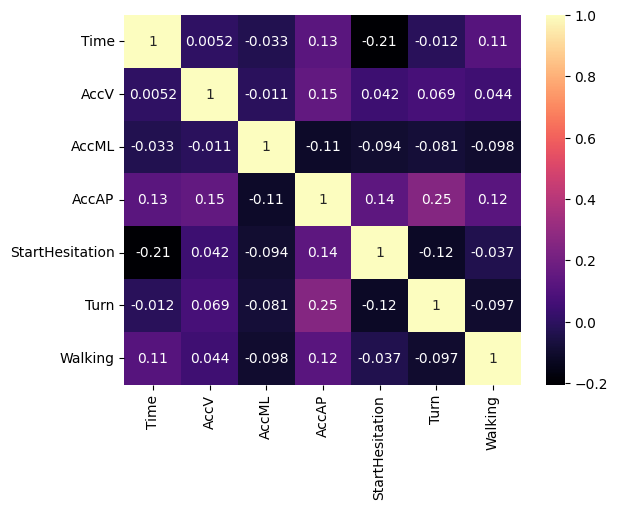

In [13]:
sns.heatmap(tdcsfog.corr(),annot= True,cmap='magma')

<Axes: xlabel='Number of 1s', ylabel='count'>

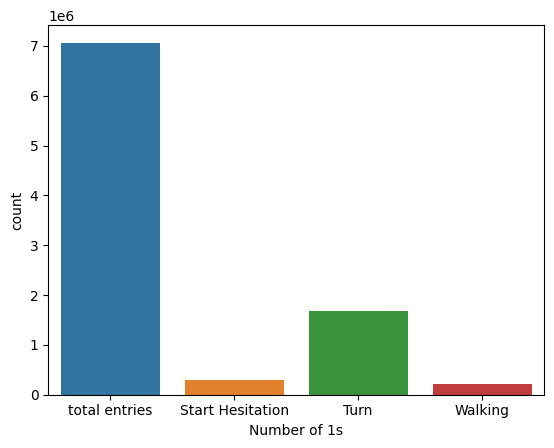

In [14]:
df2= pd.DataFrame(np.concatenate([
    ['total entries'] * len(tdcsfog),
    ['Start Hesitation'] *  int(tdcsfog['StartHesitation'].mean() * len(tdcsfog)),
    ['Turn'] * int(tdcsfog['Turn'].mean() * len(tdcsfog)),
    ['Walking'] * int(tdcsfog['Walking'].mean() * len(tdcsfog))]),
    columns= ['Number of 1s']              
    )

sns.countplot(data= df2, x='Number of 1s')

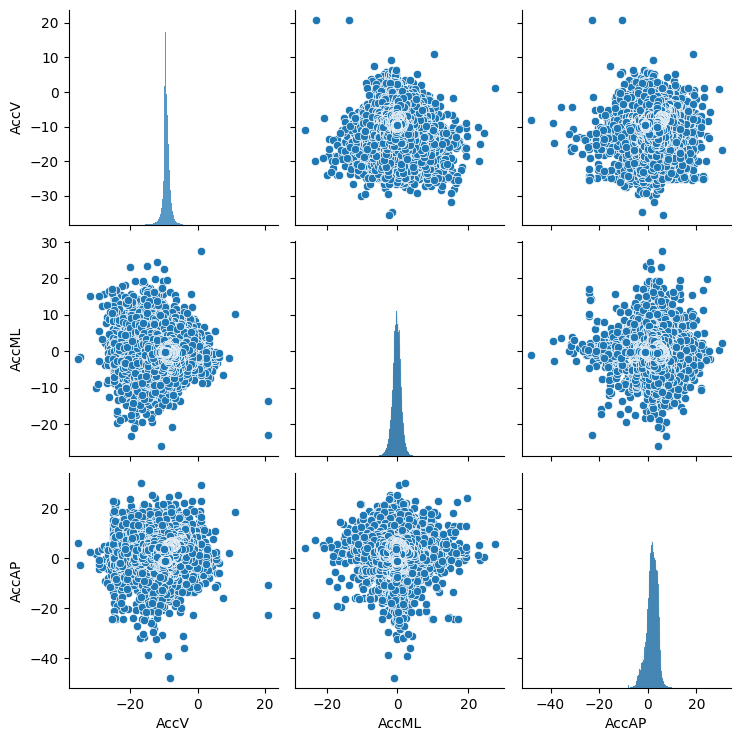

In [15]:
sns.pairplot(tdcsfog[['AccV','AccML','AccAP']])

# The Relationship between Time and the 3 Events

We should analyze **to what extent the "Time" is relevant to occurrence of "StartHesitation", "Turn", and "Walking," respectively**.  Thus, we make a figure to show the relationships between "Time" (x-axis) and "StartHesitation", "Turn", and "Walking" (y-axis).

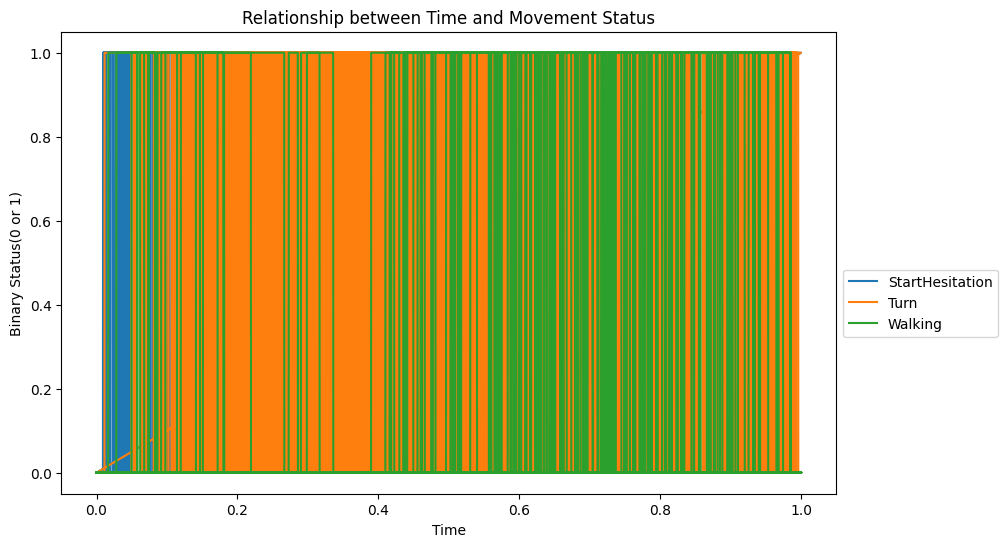

In [16]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(tdcsfog['Time'], tdcsfog['StartHesitation'], label = 'StartHesitation')
ax.plot(tdcsfog['Time'], tdcsfog['Turn'], label = 'Turn')
ax.plot(tdcsfog['Time'], tdcsfog['Walking'], label = 'Walking')

ax.set_xlabel('Time')
ax.set_ylabel('Binary Status(0 or 1)')
ax.set_title('Relationship between Time and Movement Status')

ax.legend(loc='upper left',bbox_to_anchor=(1,0.5))

**It can be seen that 'StartHesitation' has mostly occurred during specific times, mainly between 'Time' 0 to 0.1 whereas 'Walking' seems to have a positive correlation with 'Time' as it increases with 'Time'. 'Turn' seems to have the least correlation with 'Time' among the other 2 features with mostly concentrated below 'Time'= 0.5**

In [17]:
defog_path = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog'

defog_list = []

for file_name in os.listdir(defog_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(defog_path, file_name)
        file = pd.read_csv(file_path)
        file.Time = file.Time / (len(file) - 1)
        defog_list.append(file)

defog = pd.concat(defog_list, axis = 0)

defog.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0.000000,-1.002697,0.022371,0.068304,0,0,0,False,False
1,0.000008,-1.002641,0.019173,0.066162,0,0,0,False,False
2,0.000017,-0.999820,0.019142,0.067536,0,0,0,False,False
3,0.000025,-0.998023,0.018378,0.068409,0,0,0,False,False
4,0.000034,-0.998359,0.016726,0.066448,0,0,0,False,False


In [18]:
defog.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13525702 entries, 0 to 109124
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             float64
 1   AccV             float64
 2   AccML            float64
 3   AccAP            float64
 4   StartHesitation  int64  
 5   Turn             int64  
 6   Walking          int64  
 7   Valid            bool   
 8   Task             bool   
dtypes: bool(2), float64(4), int64(3)
memory usage: 851.3 MB


In [19]:
defog= reduce_memory_usage(defog)

Memory usage of dataframe is 851.34 MB
Memory usage became:  451.4690113067627  MB


<div id="3" style="background-color: #89B9AD88; padding: 12px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 32px;">
   🧪 Simple Data Preprocessing
    </h1>
</div>
<h4 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: left; color: #263A29;font-size: 20px;">

</h4>

In [20]:
defog= defog[(defog['Valid']==1) & (defog['Task']==1)]
defog.dropna()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
1000,0.008413,-1.015138,-0.071969,0.161124,0,0,0,1.0,1.0
1001,0.008421,-1.018566,-0.057850,0.144988,0,0,0,1.0,1.0
1002,0.008429,-1.037102,-0.054200,0.129327,0,0,0,1.0,1.0
1003,0.008438,-1.036416,-0.060578,0.115451,0,0,0,1.0,1.0
1004,0.008446,-1.012407,-0.069198,0.110121,0,0,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
108120,0.990799,-0.978999,0.043111,-0.392852,0,0,0,1.0,1.0
108121,0.990809,-0.949352,0.016142,-0.362455,0,0,0,1.0,1.0
108122,0.990818,-0.909800,-0.007553,-0.364498,0,0,0,1.0,1.0
108123,0.990827,-0.882329,-0.022470,-0.374119,0,0,0,1.0,1.0


In [21]:
defog= defog.iloc[:,:7]

In [22]:
merged= pd.concat([tdcsfog,defog],axis=0)
merged

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0.000000,-9.665890,0.042550,0.184744,0,0,0
1,0.000135,-9.672969,0.049217,0.184644,0,0,0
2,0.000270,-9.670260,0.033620,0.193790,0,0,0
3,0.000405,-9.673356,0.035159,0.184369,0,0,0
4,0.000541,-9.671457,0.043913,0.197814,0,0,0
...,...,...,...,...,...,...,...
108120,0.990799,-0.978999,0.043111,-0.392852,0,0,0
108121,0.990809,-0.949352,0.016142,-0.362455,0,0,0
108122,0.990818,-0.909800,-0.007553,-0.364498,0,0,0
108123,0.990827,-0.882329,-0.022470,-0.374119,0,0,0


In [23]:
X_merged = merged.iloc[:,0:4]  
X = tdcsfog.iloc[:,0:4]  
y1 = merged['StartHesitation']  # target variable for StartHesitation
y2 = merged['Turn']  # target variable for Turn
y3 = tdcsfog['Walking']  # target variable for Walking
X_merged.head()

,Time,AccV,AccML,AccAP
0,0.000000,-9.665890,0.042550,0.184744
1,0.000135,-9.672969,0.049217,0.184644
2,0.000270,-9.670260,0.033620,0.193790
3,0.000405,-9.673356,0.035159,0.184369
4,0.000541,-9.671457,0.043913,0.197814


In [24]:
y1.head()

0    0
1    0
2    0
3    0
4    0
Name: StartHesitation, dtype: int8

> **As majority of target variables are 0, we create 3 balanced datasets with equal number of 0s and 1s to get better results.****

In [25]:
y1_ones= np.where(y1==1)[0]

n1_ones= (y1==1).sum()
y1_zeros= np.random.choice(np.where(y1==0)[0],size= n1_ones,replace= False)

y1_balanced_idx= np.sort(np.concatenate([y1_zeros,y1_ones]))
y1_balanced_idx

array([      41,      160,      166, ..., 11153182, 11153198, 11153201])

In [49]:
X1_balanced= X_merged.iloc[y1_balanced_idx,:]
y1_balanced= y1.iloc[y1_balanced_idx]

In [27]:
X1_balanced.shape

(610580, 4)

In [28]:
y2_ones= np.where(y2==1)[0]

n2_ones= (y2==1).sum()
y2_zeros= np.random.choice(np.where(y2==0)[0],size= n2_ones,replace= False)

y2_balanced_idx= np.sort(np.concatenate([y2_zeros,y2_ones]))

X2_balanced= X_merged.iloc[y2_balanced_idx,:]
y2_balanced= y2.iloc[y2_balanced_idx]

In [29]:
y3_ones= np.where(y3==1)[0]

n3_ones= (y3==1).sum()
y3_zeros= np.random.choice(np.where(y3==0)[0],size= n3_ones,replace= False)

y3_balanced_idx= np.sort(np.concatenate([y3_zeros,y3_ones]))

X3_balanced= X.iloc[y3_balanced_idx,:]
y3_balanced= y3.iloc[y3_balanced_idx]

Markdown
<div id="4" style="background-color: #89B9AD88; padding: 12px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 32px;">
   🤖 Training Models
    </h1>
</div>


In [30]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_balanced, y1_balanced, test_size = 0.2, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_balanced, y2_balanced, test_size = 0.2, random_state = 42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_balanced, y3_balanced, test_size = 0.2, random_state = 42)

In [31]:
scaler1 = MinMaxScaler()
X1_train = scaler1.fit_transform(X1_train)
X1_test = scaler1.transform(X1_test)

scaler2 = MinMaxScaler()
X2_train = scaler2.fit_transform(X2_train)
X2_test = scaler2.transform(X2_test)

scaler3 = MinMaxScaler()
X3_train = scaler3.fit_transform(X3_train)
X3_test = scaler3.transform(X3_test)

<div id="4.1" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 30px;">
   4.1 Logistic Regression Model
    </h1>
</div>
<hr>

**Logistic regression is a supervised machine learning algorithm mainly used for classification tasks where the goal is to predict the probability that an instance of belonging to a given class or not. It is a kind of statistical algorithm, which analyze the relationship between a set of independent variables and the dependent binary variables**

In [32]:
model1 = LogisticRegression()
model2 = LogisticRegression()
model3 = LogisticRegression()

In [33]:
model1.fit(X1_train,y1_train)
model2.fit(X2_train,y2_train)
model3.fit(X3_train,y3_train)

LogisticRegression()

In [34]:
y1_pred = model1.predict(X1_test)
y2_pred = model2.predict(X2_test)
y3_pred = model3.predict(X3_test)

In [35]:
print('Start Hesitation \n',classification_report(y1_test,y1_pred))
print('Turn \n',classification_report(y2_test,y2_pred))
print('Walking \n',classification_report(y3_test,y3_pred))

Start Hesitation 
               precision    recall  f1-score   support

           0       0.86      0.81      0.83     61194
           1       0.82      0.87      0.84     60922

    accuracy                           0.84    122116
   macro avg       0.84      0.84      0.84    122116
weighted avg       0.84      0.84      0.84    122116

Turn 
               precision    recall  f1-score   support

           0       0.59      0.68      0.63    453201
           1       0.62      0.53      0.57    453044

    accuracy                           0.61    906245
   macro avg       0.61      0.61      0.60    906245
weighted avg       0.61      0.61      0.60    906245

Walking 
               precision    recall  f1-score   support

           0       0.76      0.72      0.74     41362
           1       0.74      0.77      0.75     41774

    accuracy                           0.75     83136
   macro avg       0.75      0.75      0.75     83136
weighted avg       0.75      0.75     

In [36]:
sh = confusion_matrix(y1_test,y1_pred)
tu = confusion_matrix(y2_test,y2_pred)
wa = confusion_matrix(y3_test,y3_pred)

**Previously, tdcsfog and defog were not merged and tdcsfog was only used**, and **the models performed reasonably well**, with accuracies ranging from 0.60 to 0.71. The precision and recall scores are also **relatively balanced for each class**, indicating that **the models are not overly biased** towards predicting one class over the other.

**The results were much better than those of the old version without making balanced datasets!**

After **merging tdcsfog and defog**, the set of **classification reports and confusion matrices seem to be better**. The precision, recall and f1-scores are generally higher in the set of reports, while the accuracy is also higher for all three categories. Additionally, the confusion matrices in the merged set show **a better balance between true positives and true negatives**, which indicates that the model is performing better overall.

### By including "Time" in the independent variables, the results for "Walking" were significantly improved!

<Axes: title={'center': 'Start Hesitation'}>

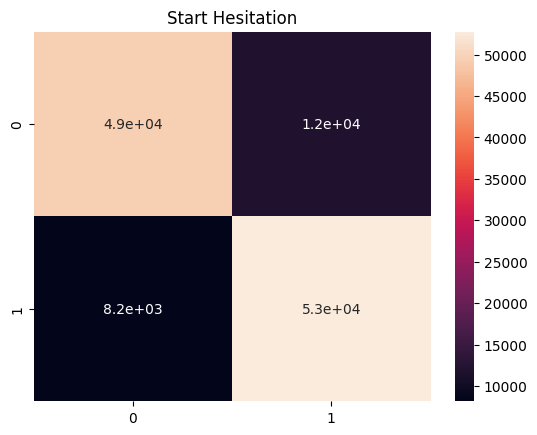

In [37]:
plt.title('Start Hesitation')
sns.heatmap(sh,annot=True)

<Axes: title={'center': 'Turn'}>

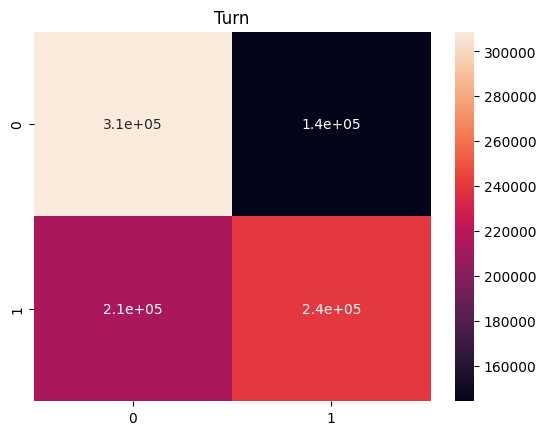

In [38]:
plt.title('Turn')
sns.heatmap(tu,annot=True)

<Axes: title={'center': 'Walikng'}>

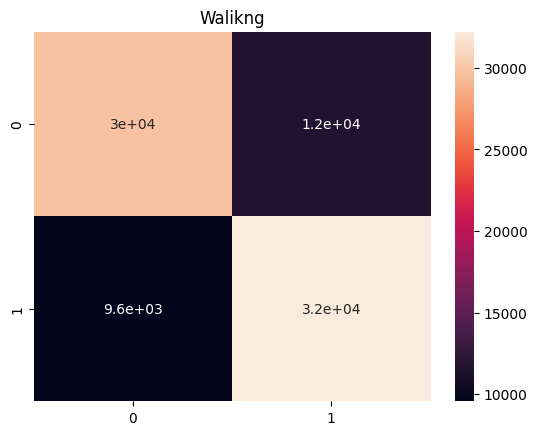

In [39]:
plt.title('Walikng')
sns.heatmap(wa,annot=True)

<div id="4.2" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 30px;">
   4.2 LGBM Model
    </h1>
</div>
<hr>

* **Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.**


In [52]:
lgbmmodel = LGBMClassifier(random_state=seed)
cv_scores = cross_val_score(lgbmmodel, X1_balanced, y1_balanced, cv=7, scoring='average_precision')
cv_mean_score = cv_scores.mean()
print("CV score of LGBM is ", cv_mean_score)

[LightGBM] [Info] Number of positive: 261677, number of negative: 261677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 523354, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 261677, number of negative: 261677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 523354, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 261677, number of negative: 261677
[LightGBM] [Info] Auto-choosing col-wise mult

* **It is almost impossible to make a machine learning algorithm do the job without tuning hyperparameters. The number of hyperparameters tends to be high, especially in deep learning, and it is believed that performance largely depends on how we tune them.**
* **Optuna is a software framework for automating the optimization process of these hyperparameters. It automatically searches for and finds optimal hyperparameter values by trial and error for excellent performance. Currently, the software can be used in Python.**

In [ ]:
# def objective(trial):
#     params = {
#         'n_estimators' : trial.suggest_int('n_estimators',500,1000),
#         "max_depth":trial.suggest_int('max_depth',3,50),
#         "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
#         "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
#         "min_child_samples" : trial.suggest_int('min_child_samples',1,250),
#         "subsample" : trial.suggest_float('subsample', 0.2, 1),
#         "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
#         "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
#         'num_leaves' : trial.suggest_int('num_leaves', 2, 128),
#     }
#     lgbmmodel_optuna = LGBMClassifier(**params,random_state=seed,device="gpu")
#     cv = cross_val_score(lgbmmodel_optuna, X1_balanced, y1_balanced, cv = 3,scoring='average_precision').mean()
#     return cv

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10,timeout=2000)

In [54]:
lgbm_params = {
    'max_depth': 8,
    'learning_rate': 0.009975674358731229,
    'min_child_weight': 0.7116049927720877,
    'min_child_samples': 35,
    'subsample': 0.44087392623500254,
    'subsample_freq': 3,
    'colsample_bytree': 0.7172664346925739,
    'num_leaves': 64
}

lgbm_opt = LGBMClassifier(**lgbm_params, n_estimators=643, random_state=seed, device="cpu")
cv_scores = cross_val_score(lgbm_opt, X1_balanced, y1_balanced, cv=4, scoring='average_precision')
cv_mean_score = cv_scores.mean()
print("CV score of LGBM Optuna is ", cv_mean_score)

[LightGBM] [Info] Number of positive: 228968, number of negative: 228967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 457935, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000004
[LightGBM] [Info] Start training from score 0.000004
[LightGBM] [Info] Number of positive: 228968, number of negative: 228967
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 457935, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000004
[LightGBM] [Info] Start training from score 0.000004
[LightGBM] [

In [56]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000,num=10)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10,1000,40)]
min_samples_split = [1,3,5,9]
min_samples_leaf = [2,4,8]
param_grid = {
    "n_estimators":n_estimators,
    "max_features":max_features,
    "max_depth":max_depth,
    "min_samples_split":min_samples_split,
    "min_samples_leaf":min_samples_leaf,
    "criterion":['gini', 'entropy', 'log_loss']
}

# Conclusion

It is possible that **more features or more advanced machine learning algorithms** could improve the accuracy of the models. Additionally, it may be useful to **investigate other factors** that contribute to the occurrence of freezing gait events, such as cognitive or environmental factors.

**Thank You**